In [17]:
import numpy as np
import jax

from jax import random
from jax import device_put
from jax import jit, vmap
from jax import numpy as jnp
from matplotlib import pyplot as plt

In [2]:
jax.default_backend()

'cpu'

## NumPy-like JAX

In [3]:
t = jnp.linspace(0,1,100)
f = jnp.sin(20 * t)

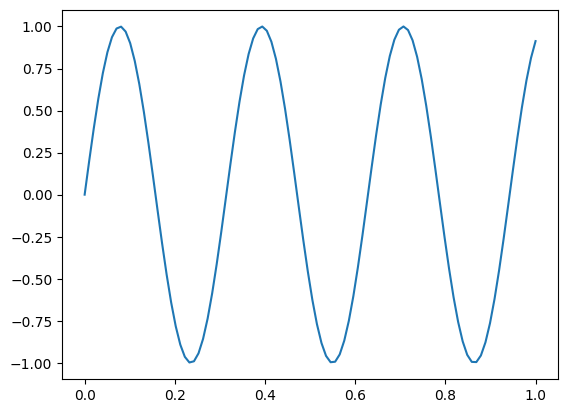

In [4]:
plt.plot(t,f)

## Immutable Arrays

In [5]:
x = jnp.arange(10)
print(x)
x[0] = 10

[0 1 2 3 4 5 6 7 8 9]


TypeError: '<class 'jaxlib.xla_extension.DeviceArray'>' object does not support item assignment. JAX arrays are immutable. Instead of ``x[idx] = y``, use ``x = x.at[idx].set(y)`` or another .at[] method: https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.ndarray.at.html

In [6]:
x = x.at[0].set(10)
print(x)

[10  1  2  3  4  5  6  7  8  9]


In [5]:
key = random.PRNGKey(0)
x = random.normal(key, (2,5))
print(x)

[[-0.3721109   0.26423115 -0.18252768 -0.7368197  -0.44030377]
 [-0.1521442  -0.67135346 -0.5908641   0.73168886  0.5673026 ]]


In [8]:
x = x.at[0].set(jnp.arange(5))
print(x)

[[ 0.          1.          2.          3.          4.        ]
 [-0.1521442  -0.67135346 -0.5908641   0.73168886  0.5673026 ]]


In [9]:
x = x.at[:,0].set(jnp.arange(2))
print(x)

[[ 0.          1.          2.          3.          4.        ]
 [ 1.         -0.67135346 -0.5908641   0.73168886  0.5673026 ]]


In [10]:
print(type(x))

<class 'jaxlib.xla_extension.DeviceArray'>


## JAX Compute = Speed

In [6]:
x_np = np.random.randn(10000,10000)
x_jnp = random.normal(key, (10000,10000))

In [7]:
%timeit jnp.dot(x_jnp, x_jnp.T)
%timeit jnp.dot(x_jnp, x_jnp.T).block_until_ready()
%timeit x_jnp @ x_jnp.T

6.8 s ± 91.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
6.84 s ± 86.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
6.96 s ± 72.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [8]:
%timeit np.dot(x_np, x_np.T)
%timeit x_np @ x_np.T

6.21 s ± 216 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
6.21 s ± 188 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [15]:
x_np_device = device_put(x_np)
%timeit jnp.dot(x_np_device, x_np_device.T).block_until_ready()
%timeit x_np_device @ x_np_device.T

107 µs ± 317 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
107 µs ± 503 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


## JAX Transformation Functions

#### Using ```jit()```

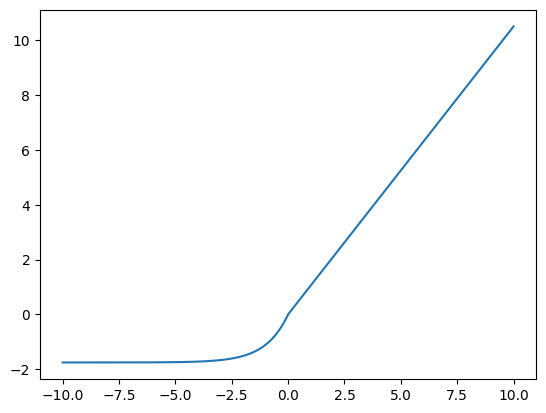

In [9]:
def selu(x, alpha=1.67, lmbda=1.05):
    return lmbda * jnp.where(x > 0, x, alpha * jnp.exp(x) - alpha)

x = jnp.linspace(-10,10,1000)
plt.plot(x, selu(x))

In [10]:
selu_jit = jit(selu)

In [11]:
data = random.normal(key, (1000000,))
%timeit selu(data).block_until_ready()
%timeit selu_jit(data).block_until_ready()

1.24 ms ± 13.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
334 µs ± 934 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)


#### Using ```grad()```

#### Using ```vmap()```

In [13]:
W = random.normal(key, (150,100))
batched_x = random.normal(key, (10,100))

def apply_matrix(x):
    return jnp.dot(W, x)

In [15]:
def naively_batched_apply_matrix(batch):
    return jnp.stack([apply_matrix(x) for x in batch])

%timeit naively_batched_apply_matrix(batched_x).block_until_ready()

792 µs ± 8.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [19]:
@jit
def batched_apply_matrix(batch):
    return jnp.dot(batch, W.T)

%timeit batched_apply_matrix(batched_x).block_until_ready()

17 µs ± 152 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [20]:
@jit
def vmap_batched_apply_matrix(batch):
    return vmap(apply_matrix)(batch)

%timeit vmap_batched_apply_matrix(batched_x).block_until_ready()

21.6 µs ± 195 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [21]:
x = random.normal(key, (10,))
print(x)